In [1]:
import csv
import pickle
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from analyticalSolver import generateQUBO, isInputValid, decodeBitstring

matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif')
BIG_TEXT = 12
MEDIUM_TEXT = 10
SMALL_TEXT = 8
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.axisbelow'] = True

# textwidth = 7.14 in
# columnwidth = 3.49 in

# Plot 1

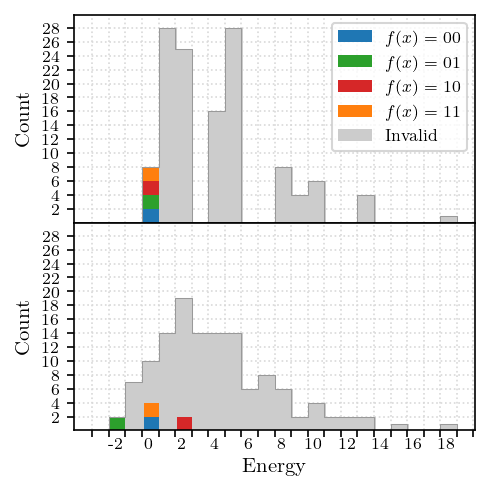

In [2]:
N = 3
PENALTIES = [None, [2, -2]]

fig, ax = plt.subplots(2, 1, figsize=(3.45, 3.6), sharex=True)
fig.subplots_adjust(hspace=0)

for idx, penalty in enumerate(PENALTIES):

    Q = generateQUBO(N, penalty, True)

    num_qubits = len(Q)

    valid = dict()
    invalid = []

    for i in range(2**num_qubits):

        x = np.array(list(map(int, list(format(i, f'0{num_qubits}b')))))
        expectation = x.T @ Q @ x

        inputs, outputs, ancillas = decodeBitstring(x)
        isValid = isInputValid(inputs, outputs, ancillas)

        if isValid:
            key = ''.join(map(str, outputs))
            if key in valid:
                valid[key].append(expectation)
            else:
                valid[key] = [expectation]
        else:
            invalid.append(expectation)
        decodedString = str(
            ''.join(map(str, inputs)) + ' ' +
            ''.join(map(str, outputs)) + ' ' +
            ''.join(map(str, ancillas))
        )

    categories = [valid[result] for result in valid]
    if idx == 1:
        categories = [[np.float64(0.0), np.float64(0.0)], [np.float64(-2.0), np.float64(-2.0)], [np.float64(2.0), np.float64(2.0)], [np.float64(0.0), np.float64(0.0)], ]
    categories.append(invalid)
    ax[idx].hist(
        categories,
        bins=np.arange(-3, 20),
        color=['C0', 'C2', 'C3', 'C1', '0.8'],
        histtype='barstacked',
        label=['$f(x) = 00$', '$f(x) = 01$', '$f(x) = 10$', '$f(x) = 11$', 'Invalid'],
        width=1.1
    )
    ax[idx].hist(
        [x for xs in categories for x in xs],
        bins=np.arange(-3, 20),
        color=['0.6'],
        histtype='step',
        linewidth=0.5
    )

    ax[idx].tick_params(which='major', labelsize=SMALL_TEXT)

    ax[idx].set_yticks(range(2, 30, 2))
    ax[idx].set_ylim(0, 29.9)
    ax[idx].set_ylabel(f'Count', fontsize=MEDIUM_TEXT)

    ticks = list(range(-3, 21, 1))
    ax[idx].set_xticks(ticks)

    labels = [str(int(tick)) if int(tick) % 2 == 0 and tick != 20 else '' for tick in ticks]

    ax[idx].set_xticklabels([])
    ax[idx].grid(which='major', color='0.85', linestyle=':')

    for tick, label in zip(ticks, labels):
        if label:
            ax[idx].text(tick + 0.4, -1, label, ha='center', va='top', fontsize=SMALL_TEXT)

    ax[0].legend(fontsize=SMALL_TEXT, frameon=True, loc='upper right')
    ax[1].set_xlabel('Energy', labelpad=6, fontsize=MEDIUM_TEXT)

plt.savefig('../figs/energySpectrum.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Plot 2

In [3]:
def Mixture(x, a, b):
    return np.maximum(np.exp(a*x**2), np.exp(b*x))

def Gaussian(x, a, b):
    return np.exp(a*x**2)

def Exponential(x, a, b):
    return np.exp(b*x)

/tmp/ipykernel_26512/3619808577.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  poptG, pcov = curve_fit(Gaussian, xVals[:8], yVals[:8], p0=[-.001, -0.062])
/tmp/ipykernel_26512/3619808577.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  poptE, pcov = curve_fit(Exponential, xVals[9:], yVals[9:], p0=[-.001, -0.062])


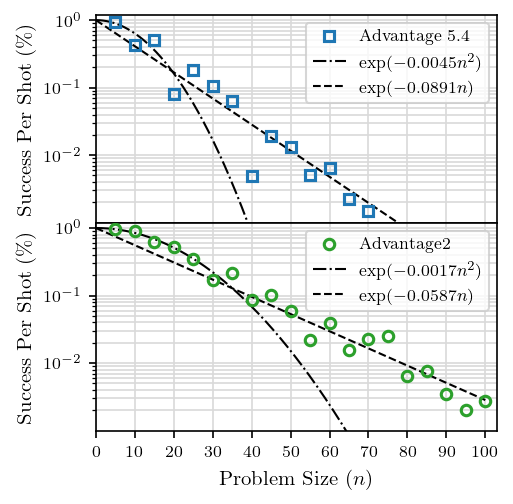

In [4]:
domain = np.linspace(0, 100, 1000)
deviceNames = ['Advantage 5.4', 'Advantage2']
fig, ax = plt.subplots(2, 1, figsize=(3.45, 3.6), sharex=True)
fig.subplots_adjust(hspace=0)

xArray = []
yArray = []
poptArray = []

for i, device in enumerate(['pegasus', 'zephyr']):
    with open(f'../data/figureData/{device}.pkl', 'rb') as file:
        data = pickle.load(file)
    rawXVals = data['xVals']
    rawYVals = data['yVals']
    xVals = []
    yVals = []
    for j, x in enumerate(rawXVals):
        if x % 5 == 0:
            xVals.append(x)
            yVals.append(rawYVals[j])    

    poptG, pcov = curve_fit(Gaussian, xVals[:8], yVals[:8], p0=[-.001, -0.062])
    poptE, pcov = curve_fit(Exponential, xVals[9:], yVals[9:], p0=[-.001, -0.062])
    popt = [poptG[0], poptE[1]]

    ax[i].semilogy(xVals, yVals, f'{"s" if i == 0 else "o"}', color=f'C{2*i}', mfc='None', ms=5, mew=1.5, label=deviceNames[i], zorder=10)
    ax[i].semilogy(domain, Gaussian(domain, *popt), linewidth=1, color='k', linestyle='-.', label=f'$\\exp({popt[0]:.4f}n^2)$')
    ax[i].semilogy(domain, Exponential(domain, *popt), linewidth=1, color='k', linestyle='--', label=f'$\\exp({popt[1]:.4f}n)$')


    ax[i].set_xlabel('Problem Size ($n$)', fontsize=MEDIUM_TEXT)
    ax[i].set_ylabel('Success Per Shot (\\%)', fontsize=MEDIUM_TEXT)
    ax[i].tick_params(which='major', labelsize=SMALL_TEXT)
    ax[i].grid(which='major', color='0.85')
    ax[i].grid(which='minor', color='0.85')
    ax[i].set_xticks(np.arange(0, 101, 10))
    ax[i].set_xlim(0, 103)
    ax[i].set_ylim(1e-3, 1.2)
    ax[i].set_yticks([1e0, 1e-1, 1e-2])

    ax[i].legend(fontsize=SMALL_TEXT, frameon=True, loc='upper right')

    xArray.append(xVals)
    yArray.append(yVals)
    poptArray.append(popt)

plt.savefig('../figs/successRate.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Plot 3

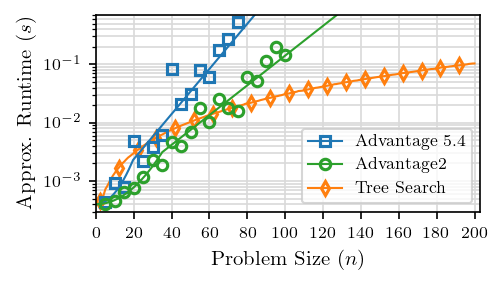

In [22]:
classical = [np.float64(0.00044956207275390623), np.float64(0.0004747629165649414), np.float64(0.0005671977996826172), np.float64(0.0007255315780639648), np.float64(0.000821995735168457), np.float64(0.0009534120559692383), np.float64(0.0010893583297729493), np.float64(0.0012411355972290039), np.float64(0.001380157470703125), np.float64(0.0015497446060180665), np.float64(0.0016789913177490234), np.float64(0.0018474817276000976), np.float64(0.0020120859146118162), np.float64(0.0021586894989013674), np.float64(0.002342367172241211), np.float64(0.0025244712829589843), np.float64(0.0026704549789428713), np.float64(0.0028414249420166014), np.float64(0.003013348579406738), np.float64(0.0032061338424682617), np.float64(0.0033914327621459963), np.float64(0.003581523895263672), np.float64(0.0038069486618041992), np.float64(0.004010319709777832), np.float64(0.004210662841796875), np.float64(0.004471278190612793), np.float64(0.004634642601013183), np.float64(0.004855680465698242), np.float64(0.005129051208496094), np.float64(0.005320405960083008), np.float64(0.005548167228698731), np.float64(0.0057628870010375975), np.float64(0.006069850921630859), np.float64(0.006259369850158692), np.float64(0.0065097808837890625), np.float64(0.006808161735534668), np.float64(0.007269454002380371), np.float64(0.007287502288818359), np.float64(0.007653236389160156), np.float64(0.007787680625915528), np.float64(0.008063888549804688), np.float64(0.008324575424194337), np.float64(0.008645939826965331), np.float64(0.008907914161682129), np.float64(0.009145092964172364), np.float64(0.009487175941467285), np.float64(0.009743762016296387), np.float64(0.010069561004638673), np.float64(0.010384273529052735), np.float64(0.010648822784423828), np.float64(0.010944676399230958), np.float64(0.011266422271728516), np.float64(0.011558461189270019), np.float64(0.011887001991271972), np.float64(0.012220430374145507), np.float64(0.012517333030700684), np.float64(0.012926697731018066), np.float64(0.013268637657165527), np.float64(0.013614249229431153), np.float64(0.013966894149780274), np.float64(0.014245891571044922), np.float64(0.014617991447448731), np.float64(0.014892506599426269), np.float64(0.015282177925109863), np.float64(0.015628767013549805), np.float64(0.016181039810180663), np.float64(0.01644287109375), np.float64(0.01684901714324951), np.float64(0.01721663475036621), np.float64(0.01758880615234375), np.float64(0.017967867851257324), np.float64(0.018524956703186036), np.float64(0.018806195259094237), np.float64(0.01924765110015869), np.float64(0.019623613357543944), np.float64(0.019988465309143066), np.float64(0.0203840970993042), np.float64(0.02112898826599121), np.float64(0.021155381202697755), np.float64(0.02159457206726074), np.float64(0.022060608863830565), np.float64(0.022489070892333984), np.float64(0.022901487350463868), np.float64(0.0233717679977417), np.float64(0.02380187511444092), np.float64(0.024380946159362794), np.float64(0.02482132911682129), np.float64(0.025292420387268068), np.float64(0.02594137191772461), np.float64(0.026231789588928224), np.float64(0.026624178886413573), np.float64(0.02706913948059082), np.float64(0.02755582332611084), np.float64(0.028198432922363282), np.float64(0.028599023818969727), np.float64(0.029173779487609863), np.float64(0.029590535163879394), np.float64(0.030314064025878905), np.float64(0.030795478820800783), np.float64(0.031215977668762208), np.float64(0.0317913293838501), np.float64(0.032279682159423825), np.float64(0.03309798240661621), np.float64(0.03345558643341064), np.float64(0.03389499187469482), np.float64(0.03489551544189453), np.float64(0.035057568550109865), np.float64(0.03532352447509766), np.float64(0.0358924388885498), np.float64(0.03646421432495117), np.float64(0.03714408874511719), np.float64(0.03763625621795654), np.float64(0.03813176155090332), np.float64(0.03879690170288086), np.float64(0.03954634666442871), np.float64(0.03990187644958496), np.float64(0.040489721298217776), np.float64(0.041086459159851076), np.float64(0.0417417049407959), np.float64(0.042303276062011716), np.float64(0.04282047748565674), np.float64(0.043330836296081546), np.float64(0.04400248527526855), np.float64(0.044608569145202635), np.float64(0.04561624526977539), np.float64(0.045931029319763186), np.float64(0.046676135063171385), np.float64(0.04713270664215088), np.float64(0.04776985645294189), np.float64(0.04869234561920166), np.float64(0.04922177791595459), np.float64(0.04989347457885742), np.float64(0.05031518936157227), np.float64(0.051011300086975096), np.float64(0.052025246620178225), np.float64(0.052366209030151364), np.float64(0.05291481018066406), np.float64(0.05386371612548828), np.float64(0.05438442230224609), np.float64(0.05539040565490723), np.float64(0.05574676990509033), np.float64(0.05652663707733154), np.float64(0.05735988616943359), np.float64(0.05789663791656494), np.float64(0.058601880073547365), np.float64(0.05919473171234131), np.float64(0.059947538375854495), np.float64(0.06072518825531006), np.float64(0.06122000217437744), np.float64(0.06252350807189941), np.float64(0.06265432834625244), np.float64(0.06324622631072999), np.float64(0.06392192840576172), np.float64(0.06503674983978272), np.float64(0.06587038040161133), np.float64(0.06646504402160644), np.float64(0.06695513725280762), np.float64(0.067755126953125), np.float64(0.06865379810333253), np.float64(0.06960859298706054), np.float64(0.07065837383270264), np.float64(0.07114303112030029), np.float64(0.07183892726898193), np.float64(0.0727163553237915), np.float64(0.07327437400817871), np.float64(0.0741530179977417), np.float64(0.07497022151947022), np.float64(0.07565646171569824), np.float64(0.07646193504333496), np.float64(0.07730779647827149), np.float64(0.07800071239471436), np.float64(0.07917308807373047), np.float64(0.07996933460235596), np.float64(0.08072714805603028), np.float64(0.08160746097564697), np.float64(0.08296780586242676), np.float64(0.08326451778411866), np.float64(0.0841282844543457), np.float64(0.08492929935455322), np.float64(0.0856553554534912), np.float64(0.08783001899719238), np.float64(0.0888897180557251), np.float64(0.08926465511322021), np.float64(0.0902977705001831), np.float64(0.09089164733886719), np.float64(0.09205420017242431), np.float64(0.09272944927215576), np.float64(0.09390127658843994), np.float64(0.09514150619506836), np.float64(0.09534580707550049), np.float64(0.09655053615570068), np.float64(0.09737250804901124), np.float64(0.09814765453338622), np.float64(0.09926235675811768), np.float64(0.09985086917877198), np.float64(0.10158030986785889), np.float64(0.10245223045349121), np.float64(0.10319788455963134), np.float64(0.10343635082244873)]
domain = np.linspace(0, 200, 1000)

fig, ax = plt.subplots(figsize=(3.45, 2))

ax.semilogy(np.arange(2, 201, 1), classical, linewidth=1, color='C1', linestyle='-')
ax.semilogy(np.arange(2, 201, 1)[::10], classical[::10], 'd', color='C1', mfc='None', ms=5, mew=1.5)
ax.semilogy(domain, 2/Mixture(domain, *poptArray[0])*(100e-6)*2, linewidth=1, color='C0', linestyle='-')
ax.semilogy(xArray[0], 2/np.array(yArray[0])*(100e-6)*2, 's', color='C0', mfc='None', ms=5, mew=1.5)
ax.semilogy(domain, 2/Mixture(domain, *poptArray[1])*(100e-6)*2, linewidth=1, color='C2', linestyle='-')
ax.semilogy(xArray[1], 2/np.array(yArray[1])*(100e-6)*2, 'o', color='C2', mfc='None', ms=5, mew=1.5)

ax.semilogy([-1], [-1], linewidth=1, color='C0', linestyle='-', marker='s', ms=5, mew=1.5, mfc='None', label='Advantage 5.4')
ax.semilogy([-1], [-1], linewidth=1, color='C2', linestyle='-', marker='o', ms=5, mew=1.5, mfc='None', label='Advantage2')
ax.semilogy([-1], [-1], linewidth=1, color='C1', linestyle='-', marker='d', ms=5, mew=1.5, mfc='None', label='Tree Search')

ax.set_xlabel('Problem Size ($n$)', fontsize=MEDIUM_TEXT)
ax.set_ylabel('Est. Time to Solution ($s$)', fontsize=MEDIUM_TEXT, y=.46)
ax.tick_params(which='major', labelsize=SMALL_TEXT)
ax.grid(which='major', color='0.85')
ax.grid(which='minor', color='0.85')
ax.set_xticks(np.arange(0, 201, 20))
ax.set_ylim(3e-4, .7)
ax.set_xlim(0, 203)

ax.legend(fontsize=SMALL_TEXT, frameon=True, loc='lower right')
fig.tight_layout()
plt.savefig('../figs/runtime.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Velox

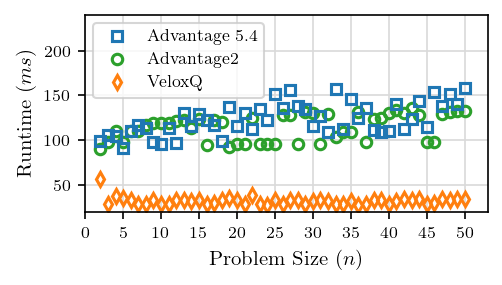

In [6]:
pegasus5_4 = {2: 99462.84, 3: 105524.92, 4: 104480.44, 5: 91434.28, 6: 110235.32, 7: 116788.12, 8: 114084.36, 9: 98314.76, 10: 95571.64, 11: 113225.8, 12: 96677.56, 13: 130838.2, 14: 115478.6, 15: 128851.24, 16: 122912.44, 17: 117035.48, 18: 99299.4, 19: 136899.48, 20: 116091.4, 21: 130408.12, 22: 112180.12, 23: 135220.12, 24: 122605.64, 25: 151339.48, 26: 135568.28, 27: 156336.6, 28: 138496.12, 29: 135140.2, 30: 115969.72, 31: 127151.0, 32: 109106.92, 33: 157438.92, 34: 112959.96, 35: 145603.48, 36: 124429.16, 37: 135482.76, 38: 111811.88, 39: 109580.76, 40: 109865.08, 41: 140055.0, 42: 112097.4, 43: 123073.08, 44: 143352.28, 45: 114515.64, 46: 153569.8, 47: 138499.32, 48: 151376.84, 49: 140606.36, 50: 158281.8}
zephyr2_6 = {2: 89590.98, 3: 97578.18, 4: 110070.98, 5: 97906.26, 6: 110562.5, 7: 110358.1, 8: 117238.98, 9: 118672.58, 10: 119491.78, 11: 119368.9, 12: 121129.78, 13: 122728.02, 14: 113347.78, 15: 123465.3, 16: 94792.5, 17: 122523.22, 18: 120679.62, 19: 92007.62, 20: 95407.7, 21: 95489.62, 22: 124406.98, 23: 95365.94, 24: 95816.9, 25: 96021.3, 26: 128503.78, 27: 128543.94, 28: 95776.74, 29: 131043.3, 30: 129896.82, 31: 96143.78, 32: 129322.58, 33: 102901.38, 34: 108924.5, 35: 109497.54, 36: 131329.22, 37: 97659.7, 38: 123546.82, 39: 125185.22, 40: 130305.22, 41: 133705.3, 42: 129772.74, 43: 136326.74, 44: 127970.5, 45: 97741.22, 46: 98274.1, 47: 129692.42, 48: 131656.9, 49: 132640.34, 50: 132148.42}

domain = np.linspace(1, 50, 1000)

veloxRuntime = []
dwaveRuntime = []
veloxEnergy = []
dwaveEnergy = []
with open('../data/figureData/results_balanced.csv', mode='r') as file:
    csvReader = csv.reader(file)
    next(csvReader)
    for row in csvReader:
        vt, ve, de, dt = row[2:-2]
        veloxRuntime.append(float(vt))
        dwaveRuntime.append(float(dt))
        veloxEnergy.append(float(ve))
        dwaveEnergy.append(float(de))

fig, ax = plt.subplots(figsize=(3.45, 2))

ax.plot(np.arange(2, 51, 1), veloxRuntime, 'd', color='C1', mfc='None', ms=5, mew=1.5)
ax.plot(zephyr2_6.keys(), np.array(list(zephyr2_6.values()))/1000, 'o', color='C2', mfc='None', ms=5, mew=1.5)
ax.plot(pegasus5_4.keys(), np.array(list(pegasus5_4.values()))/1000, 's', color='C0', mfc='None', ms=5, mew=1.5)

ax.plot([-10], [-10], linewidth=1, color='C0', linestyle='', marker='s', ms=5, mew=1.5, mfc='None', label='Advantage 5.4')
ax.plot([-10], [-10], linewidth=1, color='C2', linestyle='', marker='o', ms=5, mew=1.5, mfc='None', label='Advantage2')
ax.plot([-10], [-10], linewidth=1, color='C1', linestyle='', marker='d', ms=5, mew=1.5, mfc='None', label='VeloxQ')

ax.set_xlabel('Problem Size ($n$)', fontsize=MEDIUM_TEXT)
ax.set_ylabel('Runtime ($ms$)', fontsize=MEDIUM_TEXT)
ax.tick_params(which='major', labelsize=SMALL_TEXT)
ax.grid(which='major', color='0.85')
ax.grid(which='minor', color='0.85')
ax.set_xticks(np.arange(0, 51, 5))
ax.set_ylim(20, 240)
ax.set_xlim(0, 53)

ax.legend(fontsize=SMALL_TEXT, frameon=True, loc='upper left')
fig.tight_layout()
plt.savefig('../figs/velox.pdf', format='pdf', bbox_inches='tight')
plt.show()
